In [2]:
import librosa
import librosa.display as dsp
import sklearn
import os
import speech_recognition as sr
import json
import pandas as pd
import numpy as np
import time
import playsound
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import train_test_split
from gtts import gTTS

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font',family='Malgun Gothic')

In [76]:
# 디지털 신호와 라벨을 포함한 train Dataset 만들기
def train_dataset():
    folder_path=r'C:\Users\ej077\Downloads\전지역\전지역'
    dataset=[]

    for file in tqdm(os.listdir(folder_path), colour='green'):
        if 'wav' in file:
            abs_file_path=os.path.join(folder_path,file)
            data,sr=librosa.load(abs_file_path, sr=16000)
            f_name= file 
            if "수도권" in file: 
                 soodo_label= "수도권" 
                 dataset.append([data,soodo_label]) 
                 
            else:  
                gibang_label= f_name[str(file).find('_실')-2:str(file).find('_실')]
                dataset.append([data,gibang_label]) 
    print('Dataset 생성완료')
    return pd.DataFrame(dataset, columns=['data','sido'])

# 디지털 신호와 라벨을 포함한 test Dataset 만들기
def test_dataset():
    folder_path=r'C:\Users\ej077\ds_study\source_code\ML_project\테스트데이터'
    dataset=[]

    for file in tqdm(os.listdir(folder_path), colour='green'):
        if 'wav' in file:
            abs_file_path=os.path.join(folder_path,file)
            data,sr=librosa.load(abs_file_path, sr=16000)
            dataset.append([data,file])
    print('Dataset 생성완료')
    return pd.DataFrame(dataset, columns=['data','file_name'])

# 데이터 특징 추출
def preprocessing_train_dataset(data):
    sr=16000
    n_fft=2048
    hop_length=512
    spectrogram_features=[]
    melspectrogram_features=[]
    mfccs_features=[]

    for i in data:
        # spectrogram
        stft=librosa.stft(y=i, n_fft=n_fft, hop_length=hop_length)
        stft=np.abs(stft)
        log_spectrogram=librosa.amplitude_to_db(stft)
        log_spectrogram=np.mean(log_spectrogram.T,axis=0)
        spectrogram_features.append(log_spectrogram)

        #melspectrogram
        mel_signal=librosa.feature.melspectrogram(y=i,n_mels=40,n_fft=n_fft, hop_length=hop_length)
        #melspectrogram=np.abs(mel_signal)
        melspectrogram=np.mean(mel_signal.T,axis=0)
        melspectrogram_features.append(melspectrogram)
        
        #mfcc
        mfccs=librosa.feature.mfcc(y=i, sr=sr,n_fft=n_fft, hop_length=hop_length,n_mfcc=40)
        mfcc=np.mean(mfccs.T, axis=0)
        mfccs_features.append(mfcc)

    return np.array(spectrogram_features),np.array(melspectrogram_features),np.array(mfccs_features)
    
# 정확도 평가
def ACCURACY(true,pred):
    score=np.mean(true==pred)
    return score
# 정규화시킨 MFCC
def normalize(x,axis=0):
    return sklearn.preprocessing.minmax_scale(x,axis=axis)

# 유클리드거리 Normalize 후 거리 계산
def dist_norm(v1,v2):
    import scipy as sp
    v1_normalized=v1/sp.linalg.norm(v1.toarray())
    v2_normalized=v2/sp.linalg.norm(v2.toarray())
    delta = v1_normalized - v2_normalized

    return sp.linalg.norm(delta.toarray())

# 형태소 분석 후 말뭉치 만들기
def word_tokens(sentence_list):
    from konlpy.tag import Okt
    t=Okt()
    new_word_tokens=[t.morphs(row) for row in sentence_list]
    new_word_vectorize=[]

    for content in new_word_tokens:
        sentence=''
        for word in content:
            sentence=sentence+' '+word
        new_word_vectorize.append(sentence)
    return new_word_vectorize

# 정규화시킨 MFCC
def normalize(x,axis=0):
    return sklearn.preprocessing.minmax_scale(x,axis=axis)

##### 음성데이터 처리

##### Data Load

In [6]:
train_wav=train_dataset()

100%|██████████| 18798/18798 [01:41<00:00, 184.60it/s]


Dataset 생성완료


##### EDA

In [7]:
train_wav['sido'].sort_values().unique()

array(['경상', '수도권', '전라', '제주', '충청'], dtype=object)

In [8]:
sido_dict={'강원':0,'경상':1,'수도권':2,'전라':3,'제주':4,'충청':5}
for i in sido_dict:
    train_wav.loc[train_wav['sido']==i,'label']=sido_dict[i]
train_wav=train_wav.astype({'label':'int'})
train_wav.head()

,data,sido,label
0,"[0.00012207031, 0.0005187988, 0.0007324219, 0....",수도권,2
1,"[0.00012207031, 0.0005187988, 0.0007324219, 0....",수도권,2
2,"[0.00012207031, 0.0005187988, 0.0007324219, 0....",수도권,2
3,"[0.00012207031, 0.0005187988, 0.0007324219, 0....",수도권,2
4,"[0.00012207031, 0.0005187988, 0.0007324219, 0....",수도권,2


##### 데이터 특징 추출

In [9]:
spectrogram_features,melspectrogram_features,mfccs_features=preprocessing_train_dataset(train_wav.data)
features=[]
features.append(spectrogram_features)
features.append(melspectrogram_features)
features.append(mfccs_features)
features_name=['spectrogram','melspectrogram','mfccs_features']

C:\Users\ej077\AppData\Local\Temp\ipykernel_3476\2126821719.py:21: FutureWarning: Pass y=[0.         0.         0.         ... 0.01672363 0.01641846 0.01593018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
C:\Users\ej077\AppData\Local\Temp\ipykernel_3476\2126821719.py:21: FutureWarning: Pass y=[-0.00015259 -0.00033569 -0.00125122 ... -0.00216675 -0.00250244
 -0.0015564 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
C:\Users\ej077\AppData\Local\Temp\ipykernel_3476\2126821719.py:21: FutureWarning: Pass y=[ 0.0007019   0.00048828  0.00061035 ...  0.00036621 -0.00015259
 -0.00119019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.fe

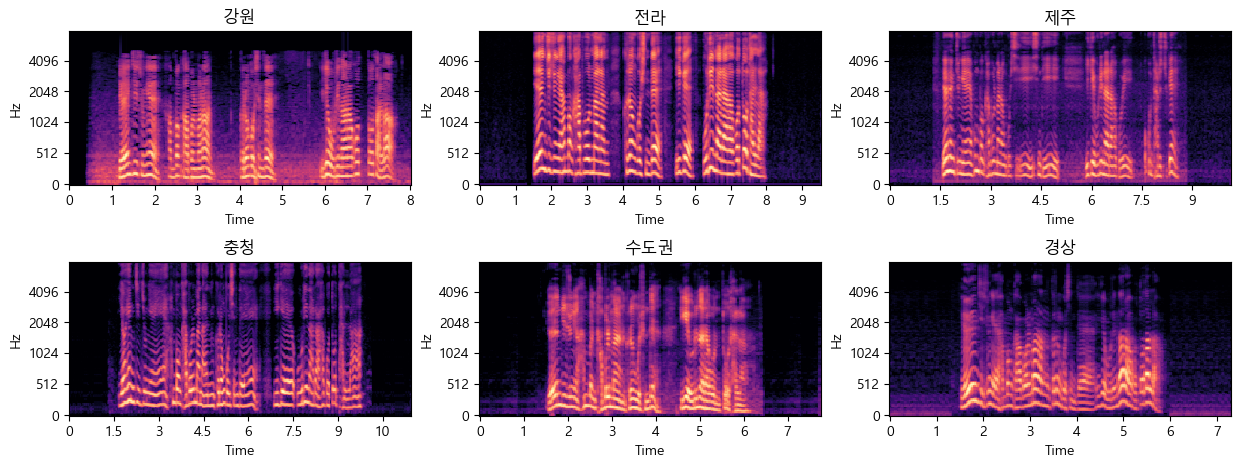

In [81]:
# 지역별 멜스토그램 
sr=16000
n_fft = 2048
hop_length = 512
n_mels = 128
folder_path=r'C:\Users\ej077\ds_study\source_code\ML_project\data_features'
i=1
j=1
plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=0.5)
for file in os.listdir(folder_path):
    if 'wav' in file:
        #지역 이름
        if '수도권' in file:
            sido='수도권'
        else:
            sido=file[str(file).find('_실')-2:str(file).find('_실')]

        abs_file_path=os.path.join(folder_path,file)
        y,sr=librosa.load(abs_file_path,sr=sr)
        S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_DB = librosa.power_to_db(S, ref=np.max)

        plt.subplot(2,3,j)
        j=j+1

        librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma');
        plt.title(sido);

C:\Users\ej077\AppData\Local\Temp\ipykernel_3476\2050003937.py:15: FutureWarning: Pass y=[0.         0.         0.         ... 0.01672363 0.01641846 0.01593018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=100, n_fft=n_fft, hop_length=hop_length)
C:\Users\ej077\AppData\Local\Temp\ipykernel_3476\2050003937.py:15: FutureWarning: Pass y=[-0.00015259 -0.00033569 -0.00125122 ... -0.00216675 -0.00250244
 -0.0015564 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=100, n_fft=n_fft, hop_length=hop_length)
C:\Users\ej077\AppData\Local\Temp\ipykernel_3476\2050003937.py:15: FutureWarning: Pass y=[ 0.0007019   0.00048828  0.00061035 ...  0.00036621 -0.00015259
 -0.00119019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(y, sr=

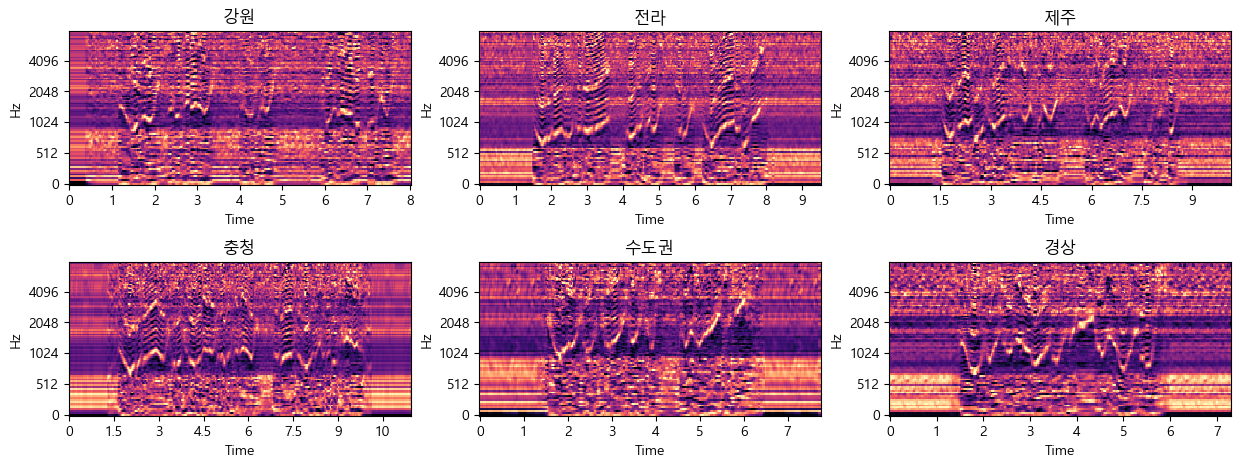

In [83]:
# 지역별 mfcc
j=1
plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=0.5)
for file in os.listdir(folder_path):
    if 'wav' in file:
        #지역 이름
        if '수도권' in file:
            sido='수도권'
        else:
            sido=file[str(file).find('_실')-2:str(file).find('_실')]

        abs_file_path=os.path.join(folder_path,file)
        y,sr=librosa.load(abs_file_path,sr=sr)
        mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=100, n_fft=n_fft, hop_length=hop_length)
        mfcc = normalize(mfcc,axis=1)

        plt.subplot(2,3,j)
        j=j+1

        librosa.display.specshow(mfcc, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma');
        plt.title(sido);

In [23]:
data=[]
results=[]
models=[]
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))

for n in range(0,len(features)):
    # 학습/검증 데이터 분리
    train_X, test_X, train_y, test_y = train_test_split(features[n], train_wav.label, test_size=0.3)
    print('train 셋 :',train_X.shape, train_y.shape)
    print('test 셋 :',test_X.shape, test_y.shape)
    
    #모델 성능확인
    for name,model in models:
        model.fit(train_X,train_y)
        pred=model.predict(test_X)
        score=ACCURACY(test_y,pred)
        data.append([features_name[n],name,round(score*100,2)])
        print(f'{name }모델의 정확도는 {score*100:.2f}% 입니다.')
    print('=========================================')

train 셋 : (6579, 1025) (6579,)
test 셋 : (2820, 1025) (2820,)
RandomForestClassifier모델의 정확도는 99.68% 입니다.
DecisionTreeClassifier모델의 정확도는 99.01% 입니다.
AdaBoostClassifier모델의 정확도는 62.87% 입니다.
train 셋 : (6579, 40) (6579,)
test 셋 : (2820, 40) (2820,)
RandomForestClassifier모델의 정확도는 98.83% 입니다.
DecisionTreeClassifier모델의 정확도는 95.85% 입니다.
AdaBoostClassifier모델의 정확도는 75.35% 입니다.
train 셋 : (6579, 40) (6579,)
test 셋 : (2820, 40) (2820,)
RandomForestClassifier모델의 정확도는 99.72% 입니다.
DecisionTreeClassifier모델의 정확도는 95.71% 입니다.
AdaBoostClassifier모델의 정확도는 68.48% 입니다.


In [24]:
result=pd.DataFrame(data,columns=['feature_algorithm','clf_model','Accuracy_score'])
result.to_excel('분류기결과.xlsx')

##### 인풋데이터로 테스트

In [12]:
test_wav=test_dataset()

100%|██████████| 6/6 [00:00<00:00, 33.04it/s]

Dataset 생성완료


In [13]:
test_wav.head()

,data,file_name
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",노인남여_노인대화48_F_cutefairy486_62_경상_실내_54199.wav
1,"[-0.00079345703, -0.00039672852, -3.0517578e-0...",노인남여_노인대화48_M_b590116_62_충청_실내_54249.wav
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",노인남여_노인대화48_M_chsoeun_70_수도권_실내_54200.wav
3,"[0.0, 0.00030517578, 0.0005493164, 0.000305175...",노인남여_노인대화49_F_ryusunt_70_강원_실내_55200.wav
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",노인남여_노인대화51_F_slk012_63_전라_실내_57205.wav


In [14]:
# 특징추출
spectrogram_test,melspectrogram_test,mfccs_test=preprocessing_train_dataset(test_wav.data)
features_test=[]
features_test.append(spectrogram_test)
features_test.append(melspectrogram_test)
features_test.append(mfccs_test)

In [16]:
# 트레인셋/검증셋 나눠 성능을 확인했던 것을 하나의 트레인 셋으로 통합하여 다시 모델 생성 후 예측
data=[]
results=[]
models=[]
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))

for i in range(0,len(features)):    
    for name,clf in models:
        col_name=f'{features_name[i]} {name}'

        #모델 학습
        model=clf
        model.fit(features[i],train_wav.label)
        
        #모델 예측
        prediction=model.predict(features_test[i])
        test_wav[col_name]=prediction

In [17]:
test_wav

,data,file_name,spectrogram RandomForestClassifier,spectrogram DecisionTreeClassifier,spectrogram AdaBoostClassifier,melspectrogram RandomForestClassifier,melspectrogram DecisionTreeClassifier,melspectrogram AdaBoostClassifier,mfccs_features RandomForestClassifier,mfccs_features DecisionTreeClassifier,mfccs_features AdaBoostClassifier
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",노인남여_노인대화48_F_cutefairy486_62_경상_실내_54199.wav,2,2,2,2,4,2,3,3,3
1,"[-0.00079345703, -0.00039672852, -3.0517578e-0...",노인남여_노인대화48_M_b590116_62_충청_실내_54249.wav,2,1,2,2,2,2,2,2,1
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",노인남여_노인대화48_M_chsoeun_70_수도권_실내_54200.wav,2,2,2,5,2,2,3,2,3
3,"[0.0, 0.00030517578, 0.0005493164, 0.000305175...",노인남여_노인대화49_F_ryusunt_70_강원_실내_55200.wav,5,3,3,2,2,2,5,2,2
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",노인남여_노인대화51_F_slk012_63_전라_실내_57205.wav,2,2,2,5,4,2,4,2,3
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",노인남여_노인대화64_F_nyanyang22_60_제주_실내_70811.wav,4,4,5,4,3,4,4,4,3


In [18]:
test_wav.to_excel('test_wav_전지역.xlsx')

In [20]:
# mfcc를 이용하여 RandomforestClassifier 하여 성능평가
model=RandomForestClassifier()
model.fit(features[2],train_wav.label)
pred=model.predict(features_test[2])

# 성능평가 
test_label=[]
for idx, row in test_wav.iterrows():
    if '수도권' in row['file_name']:
        test_label.append(2)
    else:
        f_name=row['file_name']
        f_name=f_name[str(f_name).find('_실')-2:str(f_name).find('_실')]
        test_label.append(sido_dict[f_name])

test_score=ACCURACY(test_label,pred)
print(f'{features_name[2]} RandomForestClassifier 모델의 정확도는 {score*100:.2f}% 입니다.')

mfccs_features RandomForestClassifier 모델의 정확도는 66.63% 입니다.


##### 문장 유사도

In [38]:
import re
# 대사 수집
label_path=r'C:\Users\ej077\Downloads\전지역\전지역'
dir_list=os.listdir(label_path)
label_data=[]

for item in dir_list:
    temp=os.path.join(label_path,item)
    r=sr.Recognizer()
    if 'json' in item:
        with open(temp,'r', encoding='UTF-8') as f:
            json_data=json.load(f)
            label=json_data['발화정보']['stt'].replace('\r\n','')
            rmve_bracket = "\(.*\)|\s-\s.*" #괄호와 괄호안의 정보
            label=re.sub(rmve_bracket,'',label) #(변경 전/ 변경 후/ 적용할 텍스트)
        label_data.append(label)

In [39]:
len(label_data)

9405

### CountVectorizer

In [40]:
vectorizer=CountVectorizer(min_df=1)
X=vectorizer.fit_transform(word_tokens(label_data))
num_samples, num_features=X.shape
X.toarray().transpose()
print(f'X에는 {num_samples}개의 문장에 말뭉치 단어가 총 {num_features}개 존재')

X에는 9405개의 문장에 말뭉치 단어가 총 3330개 존재


In [41]:
# 음성파일 데이터
path=r'C:\Users\ej077\ds_study\source_code\ML_project\테스트데이터'
dir_list=os.listdir(path)
best_dist=[]
text_data=[]
best_dist_post=[]

for item in dir_list:
    
    temp=os.path.join(path,item)
    r=sr.Recognizer()
    
    # STT
    with sr.AudioFile(temp) as source:
        audio=r.record(source, duration=120)
    new_post=r.recognize_google(audio_data=audio, language='ko-KR')
    new_post_list=[new_post]

    # 인풋 데이터 벡터화
    new_post_vec=vectorizer.transform(word_tokens(new_post_list))
    new_post_vec.toarray()
    
    # CountVector 정규화하여 거리 계산
    dist=[dist_norm(each, new_post_vec) for each in X]
    
    #유사도 측정
    best_dist.append(min(dist))
    text_data.append(new_post)
    best_dist_post.append(label_data[dist.index(min(dist))])

result2:
{   'alternative': [   {   'confidence': 0.75785196,
                           'transcript': '그러면 그게 바로 가야 돼서 가을에 김장할 때 파 있잖아요'},
                       {'transcript': '그러면 그게 바로가 되어서 가을에 김장할 때 파 있잖아요'},
                       {'transcript': '그러면 그게 바로 가야 돼서 가을에 김장 할 때 파 있잖아요'},
                       {'transcript': '그러면 그게 바로 가야 돼서 가을의 김장할 때 파 있잖아요'},
                       {'transcript': '그러면 그게 바로 가야 돼서 가을에 긴장할 때 파 있잖아요'}],
    'final': True}


c:\Users\ej077\anaconda3\envs\ds_study\lib\site-packages\scipy\sparse\_base.py:651: RuntimeWarning: divide by zero encountered in double_scalars
  return self.astype(np.float_)._mul_scalar(1./other)


result2:
{   'alternative': [   {   'confidence': 0.844127,
                           'transcript': '거기다 그럼 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 '
                                         '해요'},
                       {'transcript': '거기다 구름 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 해요'},
                       {'transcript': '거기다 그런 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 해요'},
                       {'transcript': '거기다 코를 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 해요'},
                       {'transcript': '거기다 콜은 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 해요'}],
    'final': True}
result2:
{   'alternative': [   {   'confidence': 0.84509754,
                           'transcript': '많이 남으면 거기 스티로폼 비닐 나온대 팔을 많이 심어 놔요'},
                       {'transcript': '많이 남으면 거기 스티로폼 비닐 나온대 팔을 많이 심어나요'},
                       {'transcript': '많이 남으면 거기 스티로폼 비닐 나온대 팔을 많이 심어 나와요'},
                       {'transcript': '많이 남으면 거기 스티로폼 비닐 나온대 8월 많이 심어 놔요'},
                       {'transcript': '많이 남으면 거기 스티로폼 비닐 나온대 8월 많이 심어나요'}],
    'final': True}
result2:
{   '

In [42]:
new_post_list

['그 주에 못 하면 그 다음 주도 일할 사람이 있으면 한 번 생각해 볼 수 있으니까']

In [43]:
import pandas as pd
data={
    'Best_dist':best_dist,
    'Input_Data':text_data,
    'Best_Post':best_dist_post
}
test=pd.DataFrame(data)
test.head()

,Best_dist,Input_Data,Best_Post
0,0.814674,그러면 그게 바로 가야 돼서 가을에 김장할 때 파 있잖아요,그러면 그게 발효가 돼서 가을에 김장할 때 파 있잖아
1,0.765367,거기다 그럼 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 해요,거기다 거름 몇 달 숙성 시켜가지고 키웠는데 요새는 와송 재배해요
2,0.305082,많이 남으면 거기 스티로폼 비닐 나온대 팔을 많이 심어 놔요,많이 남으면 거기 스티로폼 비닐 넣은 데에 파를 많이 심어놔요
3,0.000000,그러니까 이게 어거지로 한다고 해서 이렇게 되는 건 아닌 거 같더라고,그러니까 이게 어거지로 한다고 해서 이렇게 되는 건 아닌 것 같더라고
4,0.320364,나는 그래서 cgv를 자주 가는 편이야 간식은 잘 안 사먹는 편이지,나는 그래서 씨지브이를 자주 가는 편이야 간식은 잘 안 사먹는 편이지


In [45]:
for idx,row in test.iterrows():
    print('표준어 데이터 : ',row['Best_Post'])
    tts=gTTS(text=row['Best_Post'], lang='ko', slow=True)
    file_name=f"C:/Users/ej077/ds_study/source_code/ML_project/음성테스트{idx}.wav"
    tts.save(file_name)
    '''
    from IPython.display import Audio
    display(Audio(file_name, autoplay=True))
    '''

표준어 데이터 :  그러면 그게 발효가 돼서 가을에 김장할 때 파 있잖아
표준어 데이터 :  거기다 거름 몇 달 숙성 시켜가지고 키웠는데  요새는 와송 재배해요
표준어 데이터 :  많이 남으면 거기 스티로폼 비닐 넣은 데에 파를 많이 심어놔요
표준어 데이터 :  그러니까 이게 어거지로 한다고 해서 이렇게 되는 건 아닌 것 같더라고
표준어 데이터 :  나는 그래서 씨지브이를 자주 가는 편이야 간식은 잘 안 사먹는 편이지
표준어 데이터 :  그 주에 못 하면 그다음 주도 일할 사람이 있으면 한번 생각해 볼 수 있으니까


In [46]:
vectorizer=TfidfVectorizer(min_df=1, decode_error='ignore')
X=vectorizer.fit_transform(word_tokens(label_data))
num_samples, num_features=X.shape 
X.toarray().transpose() # 가중치와 역 가중치가 반영되면서 배열의 값이 바뀜
print(f'X에는 {num_samples}개의 문장에 말뭉치 단어가 총 {num_features}개 존재')

X에는 9405개의 문장에 말뭉치 단어가 총 3330개 존재


### TF-IDF

In [48]:
# 음성파일 데이터
path=r'C:\Users\ej077\ds_study\source_code\ML_project\테스트데이터'
dir_list=os.listdir(path)
best_dist=[]
text_data=[]
best_dist_post=[]

for item in dir_list[:3]:
    
    temp=os.path.join(path,item)
    r=sr.Recognizer()
    
    # STT
    with sr.AudioFile(temp) as source:
        audio=r.record(source, duration=120)
    new_post=r.recognize_google(audio_data=audio, language='ko-KR')
    new_post_list=[new_post]

    # 인풋 데이터 벡터화
    new_post_vec=vectorizer.transform(word_tokens(new_post_list))
    new_post_vec.toarray()
    
    # CountVector 정규화하여 거리 계산
    dist=[dist_norm(each, new_post_vec) for each in X]
    
    #유사도 측정
    best_dist.append(min(dist))
    text_data.append(new_post)
    best_dist_post.append(label_data[dist.index(min(dist))])

result2:
{   'alternative': [   {   'confidence': 0.75785226,
                           'transcript': '그러면 그게 바로 가야 돼서 가을에 김장할 때 파 있잖아요'},
                       {'transcript': '그러면 그게 바로가 되어서 가을에 김장할 때 파 있잖아요'},
                       {'transcript': '그러면 그게 바로 가야 돼서 가을에 김장 할 때 파 있잖아요'},
                       {'transcript': '그러면 그게 바로 가야 돼서 가을의 김장할 때 파 있잖아요'},
                       {'transcript': '그러면 그게 바로 가야 돼서 가을에 긴장할 때 파 있잖아요'}],
    'final': True}
result2:
{   'alternative': [   {   'confidence': 0.844127,
                           'transcript': '거기다 그럼 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 '
                                         '해요'},
                       {'transcript': '거기다 구름 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 해요'},
                       {'transcript': '거기다 그런 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 해요'},
                       {'transcript': '거기다 코를 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 해요'},
                       {'transcript': '거기다 콜은 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 해요'}],
    'final': True}
result2:
{   'alte

In [49]:
data={
    'Best_dist':best_dist,
    'Input_Data':text_data,
    'Best_Post':best_dist_post
}
test=pd.DataFrame(data)
test.head()

,Best_dist,Input_Data,Best_Post
0,8.344767e-01,그러면 그게 바로 가야 돼서 가을에 김장할 때 파 있잖아요,그러면 그게 발효가 돼서 가을에 김장할 때 파 있잖아
1,7.205924e-01,거기다 그럼 몇 달 숙성시켜 가지고 키웠는데 요새는 와송재배 해요,거기다 거름 몇 달 숙성 시켜가지고 키웠는데 요새는 와송 재배해요
2,3.935983e-01,많이 남으면 거기 스티로폼 비닐 나온대 팔을 많이 심어 놔요,많이 남으면 거기 스티로폼 비닐 넣은 데에 파를 많이 심어놔요
3,1.000742e-16,그러니까 이게 어거지로 한다고 해서 이렇게 되는 건 아닌 거 같더라고,그러니까 이게 어거지로 한다고 해서 이렇게 되는 건 아닌 것 같더라고
4,4.109742e-01,나는 그래서 cgv를 자주 가는 편이야 간식은 잘 안 사먹는 편이지,나는 그래서 씨지브이를 자주 가는 편이야 간식은 잘 안 사먹는 편이지


In [50]:
for idx,row in test.iterrows():
    print('표준어 데이터 : ',row['Best_Post'])
    tts=gTTS(text=row['Best_Post'], lang='ko', slow=True)
    file_name=f"C:/Users/ej077/ds_study/source_code/ML_project/음성테스트{idx}.wav"
    tts.save(file_name)

    from IPython.display import Audio
    display(Audio(file_name, autoplay=True))

표준어 데이터 :  그러면 그게 발효가 돼서 가을에 김장할 때 파 있잖아


표준어 데이터 :  거기다 거름 몇 달 숙성 시켜가지고 키웠는데  요새는 와송 재배해요


표준어 데이터 :  많이 남으면 거기 스티로폼 비닐 넣은 데에 파를 많이 심어놔요


표준어 데이터 :  그러니까 이게 어거지로 한다고 해서 이렇게 되는 건 아닌 것 같더라고


표준어 데이터 :  나는 그래서 씨지브이를 자주 가는 편이야 간식은 잘 안 사먹는 편이지


표준어 데이터 :  그 주에 못 하면 그다음 주도 일할 사람이 있으면 한번 생각해 볼 수 있으니까
